In [132]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from random import sample

### Load data, add embeddings, filter for paintings only

In [133]:
# read df from pickle 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_canonized.pkl'))

In [134]:
# load image data
ds = load_dataset("louisebrix/smk_all_paintings", split="train") # all the data is in the 'train' split

In [135]:
# load embeddings
embeddings = np.load(os.path.join(data_path, 'eva02_clip_all_paintings.npy'))
embeddings.shape

(2085, 1024)

In [136]:
grey_embeddings = np.load(os.path.join(data_path, 'GREY_eva02_clip_all_paintings.npy'))
grey_embeddings.shape

(2085, 1024)

In [137]:
# need to convert to list of arrays to add to df
embeddings_list = list(embeddings)
grey_embeddings_list = list(grey_embeddings)
df['embedding'] = embeddings_list
df['grey_embedding'] = grey_embeddings_list

In [138]:
# make sure embeddings are still np arrays and has the correct dim
print(type(df['embedding'].iloc[0]))
print(df['embedding'].iloc[0].shape)
print(type(df['grey_embedding'].iloc[0]))
print(df['grey_embedding'].iloc[0].shape)

<class 'numpy.ndarray'>
(1024,)
<class 'numpy.ndarray'>
(1024,)


In [139]:
df = df.query('main_type == "Maleri"')
indices = df.index.tolist()
df.reset_index(drop=True, inplace=True)
ds = ds.select(indices)

## Check exhibitions data

Text(0, 0.5, 'Count')

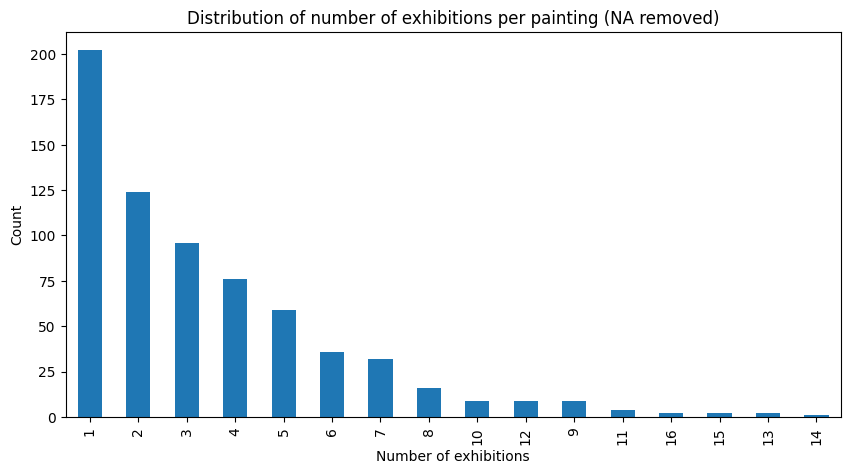

In [163]:
df['n_exhibitions'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of number of exhibitions per painting (NA removed)')
plt.xlabel('Number of exhibitions')
plt.ylabel('Count')

In [142]:
df.columns

Index(['smk_id', 'period', 'start_year', 'title', 'first_artist',
       'all_artists', 'num_artists', 'main_type', 'all_types',
       'image_thumbnail', 'gender', 'birth_death', 'nationality', 'history',
       'artist_roles', 'creator_roles', 'num_creators', 'techniques',
       'enrichment_url', 'content_person', 'has_text', 'colors',
       'geo_location', 'entropy', 'tags_en', 'image', 'rgb', 'exhibitions',
       'acquisition_date', 'responsible_department', 'documentation',
       'on_display', 'current_location_name', 'literary_reference',
       'object_history_note', 'exhibition_venues', 'smk_exhibitions',
       'golden_titles', 'exb_canon', 'docs_len', 'docs_canon', 'canon',
       'n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'embedding',
       'grey_embedding'],
      dtype='object')

In [143]:
def get_ex_dates(ex_dict_list):
    
    dates = []
    if isinstance(ex_dict_list, list):
        
        for e in ex_dict_list:
            start_date = e.get('date_start', None)

            if start_date:
                start_year = start_date.split('-')[0]
                dates.append(start_year)
            else:
                dates.append(pd.NA)
        
    else:
        dates = pd.NA
    
    return dates

In [144]:
ex_dates = [get_ex_dates(ex_dict_list) for ex_dict_list in df['exhibitions']]
df['ex_years'] = ex_dates

Text(0, 0.5, 'Count')

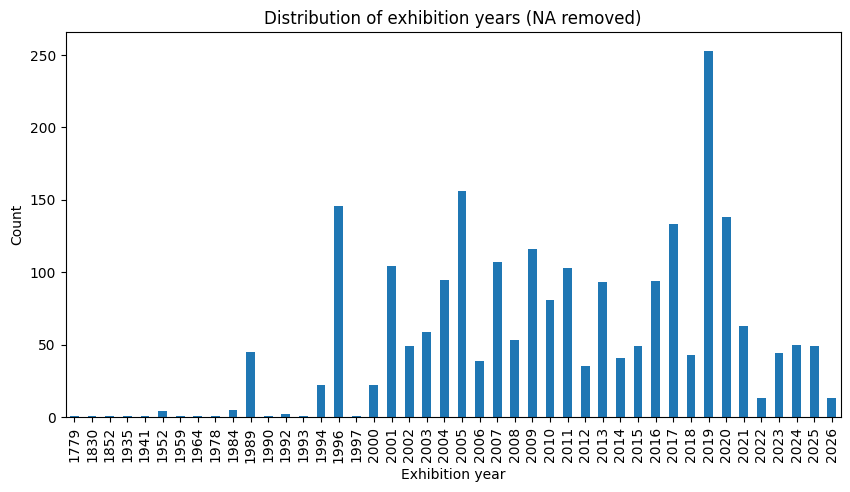

In [166]:
df['ex_years'].explode().value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of exhibition years (NA removed)')
plt.xlabel('Exhibition year')
plt.ylabel('Count')

In [149]:
def get_ex_distances(row):

    prod_year = row['start_year']
    diffs = []

    if isinstance(row['ex_years'], list):
        for year in row['ex_years']:
            if isinstance(year, str):
                diff = int(year) - int(prod_year) 
                diffs.append(diff)
            else:
                diffs.append(pd.NA)
    else:
        diffs = pd.NA
    
    return diffs

In [150]:
ex_distances = [get_ex_distances(row) for idx, row in df.iterrows()]
df['ex_distances'] = ex_distances

In [151]:
df['ex_distances'].explode().dropna().astype(int).iloc[0]

np.int64(185)

Text(0, 0.5, 'Count')

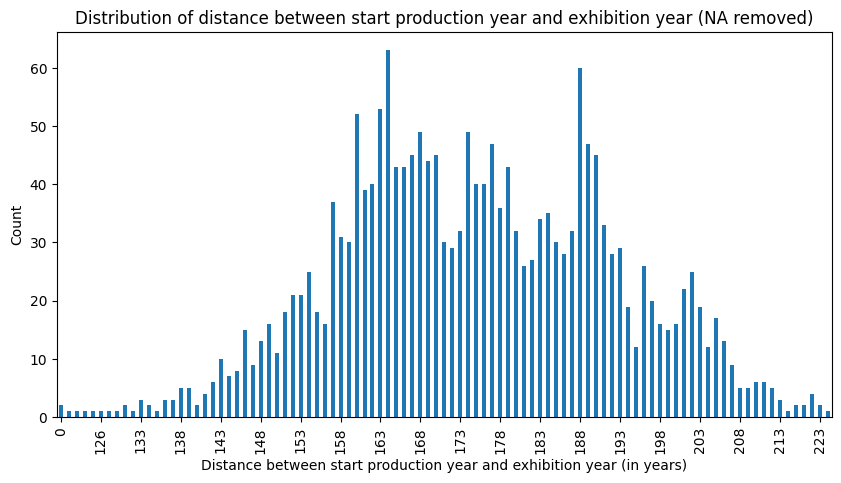

In [170]:
subset = df.query('start_year > 1800 & start_year < 1900')

year_counts = subset['ex_distances'].explode().value_counts().sort_index()
ax = year_counts.plot(kind='bar', figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(year_counts), N))
ax.set_xticklabels(year_counts.index[::5])
plt.title('Distribution of distance between start production year and exhibition year (NA removed)')
plt.xlabel('Distance between start production year and exhibition year (in years)')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

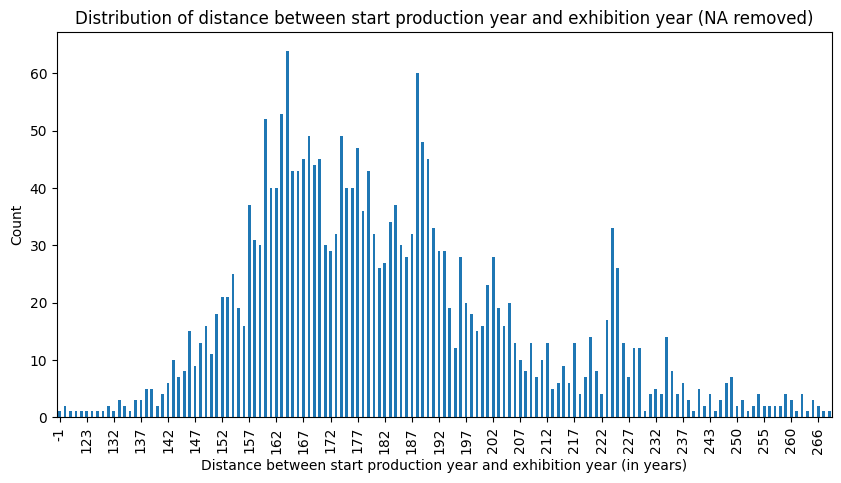

In [168]:
year_counts = df['ex_distances'].explode().value_counts().sort_index()
ax = year_counts.plot(kind='bar', figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(year_counts), N))
ax.set_xticklabels(year_counts.index[::5])
plt.title('Distribution of distance between start production year and exhibition year (NA removed)')
plt.xlabel('Distance between start production year and exhibition year (in years)')
plt.ylabel('Count')

In [153]:
df.columns

Index(['smk_id', 'period', 'start_year', 'title', 'first_artist',
       'all_artists', 'num_artists', 'main_type', 'all_types',
       'image_thumbnail', 'gender', 'birth_death', 'nationality', 'history',
       'artist_roles', 'creator_roles', 'num_creators', 'techniques',
       'enrichment_url', 'content_person', 'has_text', 'colors',
       'geo_location', 'entropy', 'tags_en', 'image', 'rgb', 'exhibitions',
       'acquisition_date', 'responsible_department', 'documentation',
       'on_display', 'current_location_name', 'literary_reference',
       'object_history_note', 'exhibition_venues', 'smk_exhibitions',
       'golden_titles', 'exb_canon', 'docs_len', 'docs_canon', 'canon',
       'n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'embedding',
       'grey_embedding', 'ex_years', 'ex_distances'],
      dtype='object')

In [154]:
exb_df = df.explode('ex_years').query('exb_canon == 1')
exb_df[exb_df['ex_years'].isnull()]

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,docs_len,docs_canon,canon,n_exhibitions,n_golden_titles,n_smk_exhibitions,embedding,grey_embedding,ex_years,ex_distances


In [156]:
def get_ex_distances_smk(row):

    if pd.notna(row['acquisition_date']):
        acq_year = row['acquisition_date'].split('-')[0]
        diffs = []

        if isinstance(row['ex_years'], list):
            for idx, year in enumerate(row['ex_years']):
                if isinstance(year, str) and isinstance(row['exhibition_venues'], list):
                    if pd.notna(row['exhibition_venues'][idx]) and row['exhibition_venues'][idx] == 'Sølvgade':
                        diff = int(year) - int(acq_year) 
                        diffs.append(diff)
                    else:
                        diffs.append(pd.NA)
                else:
                    diffs.append(pd.NA)
        else:
            diffs = pd.NA
    else:
        diffs = pd.NA
    return diffs

In [157]:
smk_distances = [get_ex_distances_smk(row) for idx, row in df.iterrows()]
df['smk_distances'] = smk_distances

Text(0, 0.5, 'Count')

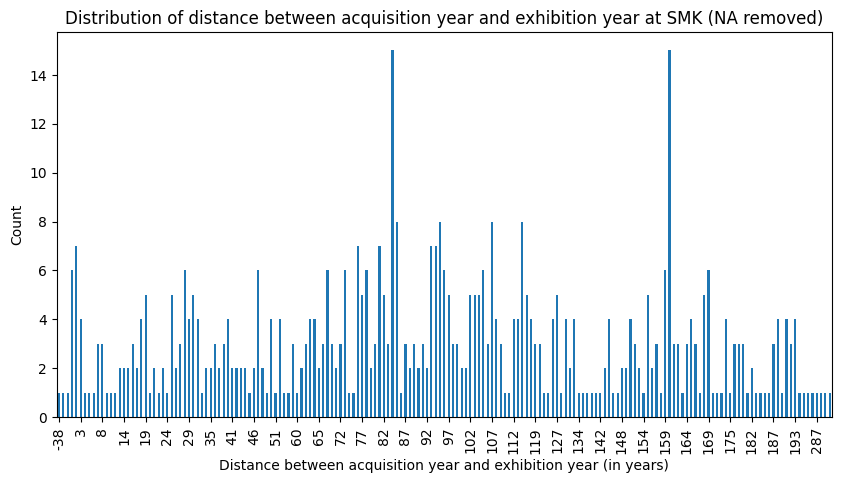

In [169]:
year_counts = df['smk_distances'].explode().value_counts().sort_index()
ax = year_counts.plot(kind='bar', figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(year_counts), N))
ax.set_xticklabels(year_counts.index[::5])
plt.title('Distribution of distance between acquisition year and exhibition year at SMK (NA removed)')
plt.xlabel('Distance between acquisition year and exhibition year (in years)')
plt.ylabel('Count')

In [173]:
dist_canon = []
for dists in df['ex_distances']:

    hej = 0
    if isinstance(dists, list):
        big_dists = [i for i in dists if i > 150]

        if len(big_dists) > 0:
            hej =+ 1
        else:
            hej =+ 0
        dist_canon.append(hej)
    else:
        dist_canon.append(0)

In [175]:
df['dist_canon'] = dist_canon

In [176]:
# write new df with canon info to disk
data_path = os.path.join('..', 'data')
df.to_pickle(os.path.join(data_path, 'paintings_canonized.pkl'))